In [1]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import deque
from IPython import display
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
from training_methods import *
%load_ext autoreload
%autoreload

run_name = 0

## Action is added to input as OHE

In [17]:
class ActionAsInputAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self._build_model()
        
    def _build_model(self):
        input_len = self.params.state_size + self.params.action_size

        self.x = tf.placeholder("float", [None, input_len], name="Placeholder_x")
        self.y = tf.placeholder("float", [None, 1], name="Placeholder_y")

        h0 = tf.contrib.layers.fully_connected(
            inputs=self.x,
            num_outputs=20,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=h0,
            num_outputs=1,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.cost = tf.nn.l2_loss(self.pred - self.y)
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
            .minimize(self.cost)

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state, frame))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        X = np.resize(state, (1, self.params.state_size + self.params.action_size))
        X[0, self.params.state_size:] = 0
        
        rewards = np.zeros((self.params.action_size))
        for i in range(self.params.action_size):
            X[0, self.params.state_size + i] = 1
            rewards[i] = session.run(self.pred, {self.x: X})[0]
            X[0, self.params.state_size + i] = 0
        return np.argmax(rewards)
    
    def think(self, batch_size, episode):
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size + self.params.action_size))
        Y = np.zeros((cnt, 1))
        for i in range(cnt):
            state, action, reward, next_state, frame = self.memory[i]
            inp = np.resize(state, (self.params.state_size + self.params.action_size))
            inp[self.params.state_size:] = 0
            inp[self.params.state_size + action] = 1
            X[i], Y[i] = inp, reward

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            batch_x = X[batch_indexes]
            batch_y = Y[batch_indexes]
            _ = session.run(self.train_op, {self.x: batch_x, self.y: batch_y})

## Policy Gradient

Run with `params.episodes_between_think = 1`

Karpathy: https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

TF interpretation: https://gist.github.com/greydanus/5036f784eec2036252e1990da21eda18

In [2]:
class PolicyGradientAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self._build_model()

    def _build_model(self):
        self.x = tf.placeholder("float", [None, self.params.state_size], name='Placeholder_x')
        self.y = tf.placeholder("float", [None, self.params.action_size], name='Placeholder_y')

        h0 = tf.contrib.layers.fully_connected(
            inputs=self.x,
            num_outputs=20,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=h0,
            num_outputs=self.params.action_size,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.cost = tf.nn.l2_loss(self.pred - self.y)

        optimizer = tf.train.RMSPropOptimizer(self.params.learning_rate_model, decay=0.99)
    
        gradients = optimizer.compute_gradients(self.cost, var_list=tf.trainable_variables())
        self.train_op = optimizer.apply_gradients(gradients)

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        act_values = session.run(self.pred, feed_dict={self.x: [state]})[0]
        return np.argmax(act_values)

    def think(self, batch_size, episode):
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = session.run(self.pred, feed_dict={self.x: [state]})[0]
            target[action] = reward
            X[i], Y[i] = state, target

        _ = session.run(self.train_op, {self.x: X, self.y: Y})

## DQN Agent

In [23]:
class DqnAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self._build_model()

    def _build_model(self):
        self.x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        self.y = tf.placeholder("float", [None, self.params.action_size], name="Placeholder_y")
        
        h0 = tf.contrib.layers.fully_connected(
            inputs=self.x,
            num_outputs=20,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=h0,
            num_outputs=self.params.action_size,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.cost = tf.nn.l2_loss(self.pred - self.y)
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
            .minimize(self.cost)
#         train_op = tf.train.AdamOptimizer(learning_rate=self.params.learning_rate_model).minimize(cost)

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        act_values = session.run(self.pred, {self.x: [state]})[0]
        return np.argmax(act_values)

    def think(self, batch_size, episode):
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = session.run(self.pred, {self.x: [state]})[0]
            target[action] = reward + self.params.gamma * \
                             np.amax(session.run(self.pred, {self.x: [next_state]})[0])
            X[i], Y[i] = state, target

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            batch_x = X[batch_indexes]
            batch_y = Y[batch_indexes]
            _ = session.run(self.train_op, {self.x: batch_x, self.y: batch_y})

In [4]:
# print(env.spec.max_episode_steps)

env = gym.make('CartPole-v1')
env.my_preprocess_input = lambda x: x

# env = gym.make('MountainCar-v0')
# env.my_preprocess_input = lambda x: x

# env = gym.make('Breakout-v0')
# env.my_preprocess_input = preprocess_input_breakout_v0

# env = gym.make('Pong-v0')
# env.my_preprocess_input = preprocess_input_pong_v0

# env.render(close=True)
# plt.imshow(env.render('rgb_array'))
print('Actions: {}, Observation space {}, {} parameters'.format(
    env.action_space.n, env.observation_space.shape, np.prod(env.observation_space.shape)))

[2017-08-18 17:42:39,540] Making new env: CartPole-v1


Actions: 2, Observation space (4,), 4 parameters


In [10]:
# Experimenting with env

print(env.spec.max_episode_steps)
state = env.reset()
env.step(1)
# for i in range(10):
#     state, reward, _, _ = env.step(1)
state, reward, _, _ = env.step(1)
# state, reward, _, _ = env.step(2)
# state, reward, _, _ = env.step(3)
# state, reward, _, _ = env.step(3)
print(state.shape)
print(reward)

500
(4,)
1.0


In [ ]:
# env.reset()
state, reward, next_state, done = env.step(2)
state = env.my_preprocess_input(state)
print(state.shape, reward)
# prepro(state).reshape((80, 80)).shape
plt.imshow(state.reshape((19, 16)), cmap='Greys')
# plt.imshow(env.render('rgb_array'))

State shape (4,), actions 2
Run: 11
episode: 7/150, reward 22.4285714286, frames 42, exploration rate: 0.9
episode: 14/150, reward 26.5, frames 15, exploration rate: 0.79
episode: 21/150, reward 35.7, frames 90, exploration rate: 0.68
episode: 28/150, reward 58.9, frames 42, exploration rate: 0.59
episode: 35/150, reward 80.5, frames 257, exploration rate: 0.52
episode: 42/150, reward 148.3, frames 84, exploration rate: 0.45
episode: 49/150, reward 211.4, frames 128, exploration rate: 0.39
episode: 56/150, reward 199.5, frames 313, exploration rate: 0.34
episode: 63/150, reward 242.3, frames 234, exploration rate: 0.3
episode: 70/150, reward 258.7, frames 216, exploration rate: 0.26
episode: 77/150, reward 238.1, frames 284, exploration rate: 0.22
episode: 84/150, reward 206.2, frames 161, exploration rate: 0.19
episode: 91/150, reward 149.7, frames 151, exploration rate: 0.17
episode: 98/150, reward 156.0, frames 170, exploration rate: 0.15
episode: 105/150, reward 166.2, frames 157, 

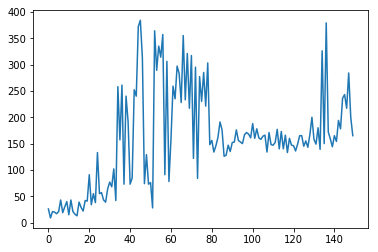

In [22]:
params = LearningParameters(env, episodes_count=150)
params.max_frame_in_episode = min(params.max_frame_in_episode, 10000)
params.epsilon_min = 0.05

if 'session' in locals():
    session.close()
    tf_writer.close()
config = tf.ConfigProto(device_count = {'GPU': 0})
session = tf.Session(config=config)
run_name += 1
print('Run: ' + str(run_name))

agent = PolicyGradientAgent(params)
# agent = DqnAgent(params)
# agent = ActionAsInputAgent(params)

tf_writer = tf.summary.FileWriter('logs/run' + str(run_name), session.graph)

session.run(tf.global_variables_initializer())

agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=True)
# agent, rewards = train_reward_is_time(env, agent, params)
# agent, rewards = train(env, agent, params)
plt.plot(rewards)

In [ ]:
# Continue learning
params.episodes_count = 10000
agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=True)
plt.plot(rewards)

In [20]:
evaluate(env, agent, params, 500)

Total reward: 9.0


In [ ]:
show(env, agent, params, 500, width=19, height=16, greedy=True)

In [ ]:
# Save rewards/model
pd.DataFrame(rewards).to_csv('models/rewards_40K_50K.csv', header=None)
saver = tf.train.Saver()
saver.save(session, 'models/Pong PolicyGradient', global_step=50000)